In [1]:
using Markdown
using InteractiveUtils

macro bind(def, element)
    quote
        local el = $(esc(element))
        global $(esc(def)) = Core.applicable(Base.get, el) ? Base.get(el) : missing
        el
    end
end

@bind (macro with 1 method)

In [1]:
using Pkg

Pkg.activate(raw"G:\molloi-lab\project-distance-transforms\julia_env_wenboPC")
Pkg.Registry.update()
        # Pkg.activate(mktempdir())
Pkg.instantiate()
        # Pkg.Registry.update()
        # Pkg.add("PlutoUI")
        # Pkg.add("Tar")
        # Pkg.add("MLDataPattern")
        # Pkg.add("Glob")
        # Pkg.add("NIfTI")
        # Pkg.add("DataAugmentation")
        # Pkg.add("CairoMakie")
        # Pkg.add("ImageCore)
        # Pkg.add("DataLoaders")
        # Pkg.add("CUDA")
        # Pkg.add(Pkg.PackageSpec(;name="FastAI", version="0.2.0"))
        # Pkg.add(url = "https://github.com/FluxML/Metalhead.jl")
        

  Activating project at `G:\molloi-lab\project-distance-transforms\julia_env_wenboPC`
    Updating registry at `C:\Users\Administrator.WIN-2EPKD7D6018\.julia\registries\General.toml`


In [2]:
using PlutoUI
using Tar
using MLDataPattern
using Glob
using NIfTI
using DataAugmentation
using DataAugmentation: OneHot, Image
using CairoMakie
using ImageCore
using DataLoaders
using CUDA
using FastAI
using Metalhead
using StaticArrays
#using torch

In [4]:
@show CUDA.functional()

CUDA.functional() = true


true

In [5]:
@show CUDA.device()

CUDA.device() = CuDevice(0)


CuDevice(0): NVIDIA GeForce RTX 2080 Ti

## Load data
Part of the [Medical Decathlon Dataset](http://medicaldecathlon.com/)

In [6]:
data_dir = raw"G:\molloi-lab\project-distance-transforms\Task02_Heart"

"G:\\molloi-lab\\project-distance-transforms\\Task02_Heart"

In [7]:
function loadfn_label(p)
    a = NIfTI.niread(string(p)).raw
    convert_a = convert(Array{UInt8}, a)
    convert_a = convert_a .+ 1
    return convert_a
end

function loadfn_image(p)
    a = NIfTI.niread(string(p)).raw
    convert_a = convert(Array{Float32}, a)
    convert_a = convert_a / max(convert_a...)
    return convert_a
end

loadfn_image (generic function with 1 method)

In [8]:
niftidata_image(dir) = mapobs(loadfn_image, Glob.glob("*.nii*", dir))
niftidata_label(dir) =  mapobs(loadfn_label, Glob.glob("*.nii*", dir))
data = (
    niftidata_image(joinpath(data_dir, "imagesTr")),
    niftidata_label(joinpath(data_dir, "labelsTr")),
    )

(mapobs(loadfn_image, ["G:\\molloi-lab\\project-distance-transforms\\Task02_Heart\\imagesTr\\la_003.ni…]), mapobs(loadfn_label, ["G:\\molloi-lab\\project-distance-transforms\\Task02_Heart\\labelsTr\\la_003.ni…]))

In [9]:
train_files, val_files = MLDataPattern.splitobs(data, 0.8)

((DataSubset(::FastAI.Datasets.MappedData{typeof(loadfn_image), Vector{String}}, ::UnitRange{Int64}, ObsDim.Undefined())
 16 observations, DataSubset(::FastAI.Datasets.MappedData{typeof(loadfn_label), Vector{String}}, ::UnitRange{Int64}, ObsDim.Undefined())
 16 observations), (DataSubset(::FastAI.Datasets.MappedData{typeof(loadfn_image), Vector{String}}, ::UnitRange{Int64}, ObsDim.Undefined())
 4 observations, DataSubset(::FastAI.Datasets.MappedData{typeof(loadfn_label), Vector{String}}, ::UnitRange{Int64}, ObsDim.Undefined())
 4 observations))

## Create learning method

In [10]:
struct ImageSegmentationSimple <: DLPipelines.LearningMethod
    imagesize
end

In [11]:
image_size = (96, 96, 96)

(96, 96, 96)

In [12]:
method = ImageSegmentationSimple(image_size)

ImageSegmentationSimple((96, 96, 96))

### Set up `encode` pipelines

In [13]:
function DLPipelines.encode(
    method::ImageSegmentationSimple,
    context::Training,
    (image, target)::Union{Tuple, NamedTuple}
    )

    tfm_proj = RandomResizeCrop(method.imagesize)
    tfm_im = DataAugmentation.compose(
        ImageToTensor(),
        NormalizeIntensity()
        )
    tfm_mask = OneHot()

    items = Image(Gray.(image)), MaskMulti(target)
    item_im, item_mask = apply(tfm_proj, (items))

    return itemdata(apply(tfm_im, item_im)), itemdata(apply(tfm_mask, item_mask))
end

function DLPipelines.encode(
    method::ImageSegmentationSimple,
    context::Validation,
    (image, target)::Union{Tuple, NamedTuple}
    )

    tfm_proj = CenterResizeCrop(method.imagesize)
    tfm_im = DataAugmentation.compose(
        ImageToTensor(),
        NormalizeIntensity()
        )
    tfm_mask = OneHot()

    items = Image(Gray.(image)), MaskMulti(target)
    item_im, item_mask = apply(tfm_proj, (items))

    return itemdata(apply(tfm_im, item_im)), itemdata(apply(tfm_mask, item_mask))
end

In [14]:

methoddata_train = DLPipelines.MethodDataset(train_files, method, Training())
methoddata_valid = DLPipelines.MethodDataset(val_files, method, Validation())

DLPipelines.MethodDataset{ImageSegmentationSimple}
  data: Tuple{DataSubset{FastAI.Datasets.MappedData{typeof(loadfn_image), Vector{String}}, UnitRange{Int64}, LearnBase.ObsDim.Undefined}, DataSubset{FastAI.Datasets.MappedData{typeof(loadfn_label), Vector{String}}, UnitRange{Int64}, LearnBase.ObsDim.Undefined}}
  method: ImageSegmentationSimple
  context: Validation Validation()


In [15]:
x, y = MLDataPattern.getobs(methoddata_valid, 1)
@assert size(x) == (image_size..., 1)
@assert size(y) == (image_size..., 2)

## Visualize

In [16]:
@show size(x)

size(x) = (96, 96, 96, 1)


(96, 96, 96, 1)

In [17]:
@show size(y)

size(y) = (96, 96, 96, 2)


(96, 96, 96, 2)

In [18]:
@bind b PlutoUI.Slider(1:size(x)[3], default=50, show_value=true)

PlutoUI.BuiltinsNotebook.Slider{Int64}(1:96, 50, true)

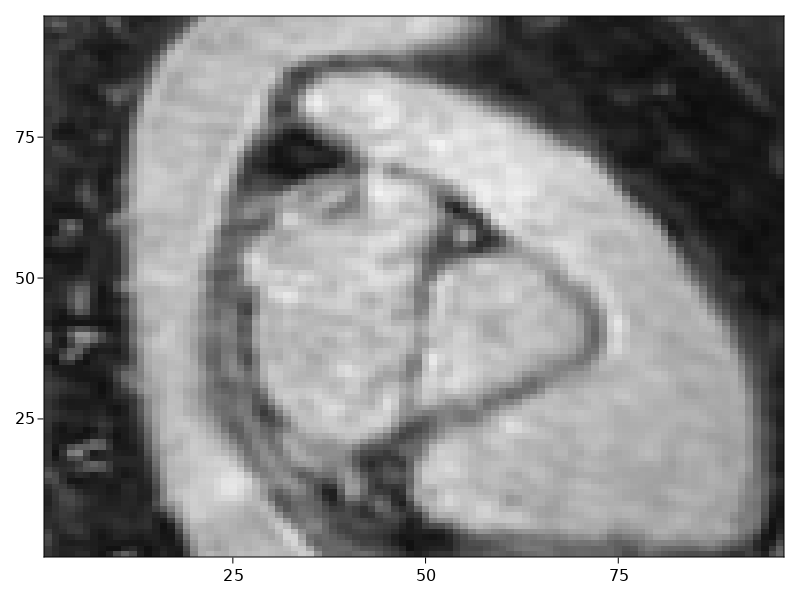

In [19]:
heatmap(x[:, :, b, 1], colormap=:grays)

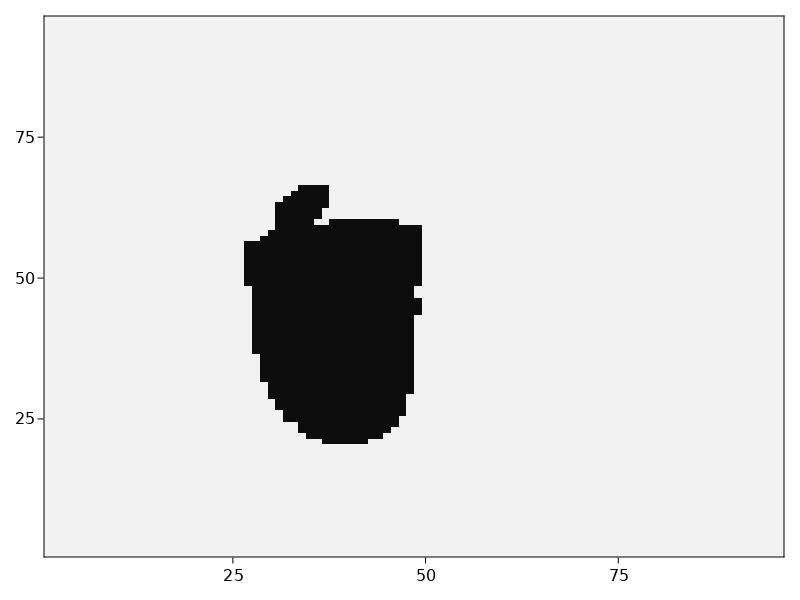

In [20]:
heatmap(y[:, :, b, 1], colormap=:grays)

## Dataloader

In [21]:
train_loader = DataLoaders.DataLoader(methoddata_train, 1)
val_loader = DataLoaders.DataLoader(methoddata_valid, 4)

DataLoaders.GetObsParallel{DataLoaders.BatchViewCollated{DLPipelines.MethodDataset{ImageSegmentationSimple}}}(batchviewcollated() with 1 batches of size 4, false)

In [22]:
train_loader

DataLoaders.GetObsParallel{DataLoaders.BatchViewCollated{DLPipelines.MethodDataset{ImageSegmentationSimple}}}(batchviewcollated() with 16 batches of size 1, false)

In [23]:
val_loader

DataLoaders.GetObsParallel{DataLoaders.BatchViewCollated{DLPipelines.MethodDataset{ImageSegmentationSimple}}}(batchviewcollated() with 1 batches of size 4, false)

## Model

In [24]:
# 3D layer utilities
conv = (stride, in, out) -> Conv((3, 3, 3), in=>out, stride=stride, pad=(1, 1, 1))
tran = (stride, in, out) -> ConvTranspose((4, 4, 4), in=>out, stride=stride, pad=1)

conv1 = (in, out) -> Chain(conv(1, in, out), BatchNorm(out), x -> leakyrelu.(x))
conv2 = (in, out) -> Chain(conv(2, in, out), BatchNorm(out), x -> leakyrelu.(x))
tran2 = (in, out) -> Chain(tran(2, in, out), BatchNorm(out), x -> leakyrelu.(x))

#21 (generic function with 1 method)

In [25]:
function unet3D(in_chs, lbl_chs)
    # Contracting layers
    l1 = Chain(conv1(in_chs, 4))
    l2 = Chain(l1, conv1(4, 4), conv2(4, 16))
    l3 = Chain(l2, conv1(16, 16), conv2(16, 32))
    l4 = Chain(l3, conv1(32, 32), conv2(32, 64))
    l5 = Chain(l4, conv1(64, 64), conv2(64, 128))

    # Expanding layers
    l6 = Chain(l5, tran2(128, 64), conv1(64, 64))
    l7 = Chain(Parallel(+, l6, l4), tran2(64, 32), conv1(32, 32))       # Residual connection between l6 & l4
    l8 = Chain(Parallel(+, l7, l3), tran2(32, 16), conv1(16, 16))       # Residual connection between l7 & l3
    l9 = Chain(Parallel(+, l8, l2), tran2(16, 4), conv1(4, 4))          # Residual connection between l8 & l2
    l10 = Chain(l9, conv1(4, lbl_chs))
end

unet3D (generic function with 1 method)

In [26]:
model = unet3D(1, 2) |> gpu;

## Helper functions

In [27]:
function dice_metric(ŷ, y)
    dice = 2 * sum(ŷ .& y) / (sum(ŷ) + sum(y))
    return dice
end

dice_metric (generic function with 1 method)

In [28]:
function as_discrete(array, logit_threshold)
    array = array .>= logit_threshold
    return array
end

as_discrete (generic function with 1 method)

## Loss functions

In [29]:
function dice_loss(ŷ, y)
    ϵ = 1e-5
    return loss = 1 - ((2 * sum(ŷ .* y) + ϵ) / (sum(ŷ .* ŷ) + sum(y .* y) + ϵ))
end

dice_loss (generic function with 1 method)

In [30]:
function hd_loss(ŷ, y, ŷ_dtm, y_dtm)
    M = (ŷ .- y) .^ 2 .* (ŷ_dtm .^ 2 .+ y_dtm .^ 2)
    return loss = mean(M)
end

hd_loss (generic function with 1 method)

## Training

In [31]:
ps = Flux.params(model);
loss_function = dice_loss
optimizer = Flux.ADAM(0.01)

ADAM(0.01, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [32]:
max_epochs = 1
val_interval = 1
epoch_loss_values = []
val_epoch_loss_values = []
dice_metric_values = []

Any[]

In [33]:
for (xs, ys) in val_loader
	@show size(xs)
	@show size(ys)
end

size(xs) = (96, 96, 96, 1, 4)
size(ys) = (96, 96, 96, 2, 4)


In [34]:
for epoch in 1:max_epochs
    step = 0
    @show epoch
    
    # Loop through training data
    for (xs, ys) in train_loader
        xs, ys = xs |> gpu, ys |> gpu
        step += 1
        @show step
        gs = Flux.gradient(ps) do
            ŷs = model(xs)
            loss = loss_function(ŷs[:, :, :, 2, :], ys[:, :, :, 2, :])
            return loss
        end
        Flux.update!(optimizer, ps, gs)
    end

    # Loop through validation data
    if (epoch + 1) % val_interval == 0
        val_step = 0
        for (val_xs, val_ys) in val_loader
            val_xs, val_ys = val_xs |> gpu, val_ys |> gpu 
            val_step += 1
            @show val_step

            local val_ŷs = model(val_xs)
            local val_loss = loss_function(val_ŷs[:, :, :, 2, :], val_ys[:, :, :, 2, :])
            val_ŷs, val_ys = as_discrete(val_ŷs, 0.5), as_discrete(val_ys, 0.5)
        end
    end
end

epoch = 1
step = 1
step = 2
step = 3
step = 4
step = 5
step = 6
step = 7
step = 8
step = 9
step = 10
step = 11
step = 12
step = 13
step = 14
step = 15
step = 16
val_step = 1
